# Test on real data

In [19]:
# Load libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import time

In [20]:
# Import written libraries
import src.utils as ut
import src.fuzz as fz
import src.classif as cl

## Iris dataset

In [21]:
iris = load_iris(as_frame=True)  # returns a dict-like object
df = iris.frame  # get as pandas DataFrame

In [22]:
X = df.drop(columns='target')  # features
y = df['target']  # target

# Turn into array
X = np.array(X)
y = np.array(y)

In [23]:
# Hyperparameters
dim = X.shape[1]  # number of features
nb_classes = len(np.unique(y))  # number of classes

# Normalize data
data_norm = fz.batch_norm(X)
data_labels = ut.convert_to_float_lst(y)
print(f"Normalized data: {data_norm.shape[0]} samples in {data_norm.shape[1]}D space.")

Normalized data: 150 samples in 4D space.


[0, 0.2249285260013124, 0.26754332266087055, 0.2858964533344943, 0.43831760646571727, 0.45549636267792404, 0.4731646789696685, 0.6125676117141979, 0.6445820953938981, 0.6617081243866275, 0.7113752159488872, 0.7286829183658481, 0.8537691252087923, 0.9018802503768522, 0.9024675287465607, 0.9980897692990406]
Leave one out avec k = 1
SimLevel1: 0.6666666666666666
SimLevel2: 0.6666666666666666
SimLevel3: 0.6666666666666666

Result in 3.0601 seconds.
[0, 0.001180216524972133, 0.06296036963032314, 0.06623981960576109, 0.08227494380020584, 0.23758494879798886, 0.3251306099343413, 0.3993790778174162, 0.5124121564783745, 0.5327356944582474, 0.6030700230957167, 0.6848052431973608, 0.6866259025541886, 0.7469866589624765, 0.8361997541254964, 0.9978391912831738]
Leave one out avec k = 2
SimLevel1: 0.6666666666666666
SimLevel2: 0.6666666666666666
SimLevel3: 0.6666666666666666

Result in 2.8011 seconds.
[0, 0.006560755537380669, 0.04456343269346985, 0.1222766493934968, 0.20281255827061906, 0.217862007

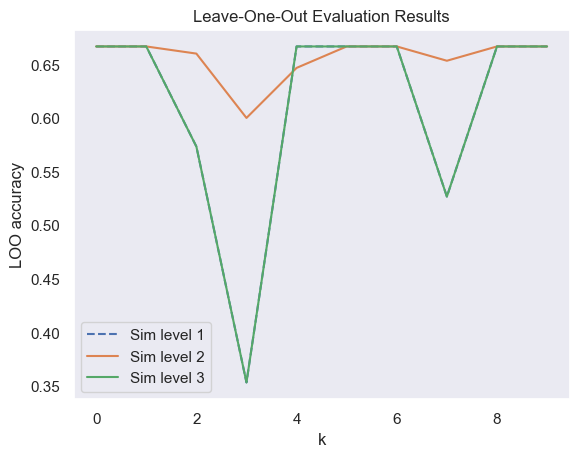

In [26]:
# LOO evaluation
# Define list for each sim level
l1 = []
l2 = []
l3 = []
k = 10

for k in range(1, k+1): 
    tic = time.time()
    mu = fz.generate_capacity(ut.enumerate_permute_batch(data_norm[0]),2**len(data_norm[0])-1)
    print(mu)

    print(f"Leave one out avec k = {k}")
    
    # SimLevel1
    res = cl.leave_one_out(
            C = cl.KNNFuzz(input_dimension=data_norm.shape[1],mu=mu, k=k, sim=fz.SimLevel1), 
            DS = (data_norm, data_labels)
        )
    l1.append(res)
    print(f"SimLevel1: {res}")
    # Sim level 2
    res = cl.leave_one_out(
            C = cl.KNNFuzz(input_dimension=data_norm.shape[1],mu=mu, k=k, sim=fz.SimLevel2), 
            DS = (data_norm, data_labels)
        )
    l2.append(res)
    print(f"SimLevel2: {res}")

    # Sim level 3
    res = cl.leave_one_out(
            C = cl.KNNFuzz(input_dimension=data_norm.shape[1],mu=mu, k=k, sim=fz.SimLevel3), 
            DS = (data_norm, data_labels)
        )
    l3.append(res)
    print(f"SimLevel3: {res}\n")

    toc = time.time()
    print(f"Result in {(toc-tic):0.4f} seconds.")

# Plot results
plt.plot(l1, label="Sim level 1", linestyle='dashed')
plt.plot(l2, label="Sim level 2")
plt.plot(l3, label="Sim level 3")

# Config additional params
plt.ylabel("LOO accuracy")
plt.xlabel(r"k")
plt.title("Leave-One-Out Evaluation Results")
plt.grid()
plt.legend()
plt.savefig("archive/iris_accuracy.png")